In [65]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import os
import random

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [3]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [4]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [5]:
#%tensorboard --logdir logs/fit
%tensorboard --logdir ./logs --host 0.0.0.0

In [6]:
#%reload_ext tensorboard

In [7]:
#path = '../dataset/gemini_BTCUSD_2019_1min.csv'
path = '../../dataset/gemini_BTCUSD_2019_1min.csv'
# Skipping the first line of the csv-file
with open(path, 'r') as f:
    next(f)
    df = pd.read_csv(f, parse_dates = ['Date'])#, index_col = 'Date')

print(df.head())

   Unix Timestamp                Date  Symbol     Open     High      Low  \
0   1592352000000 2020-06-17 00:00:00  BTCUSD  9526.40  9539.67  9526.40   
1   1592351940000 2020-06-16 23:59:00  BTCUSD  9525.68  9532.30  9525.68   
2   1592351880000 2020-06-16 23:58:00  BTCUSD  9521.38  9531.92  9521.38   
3   1592351820000 2020-06-16 23:57:00  BTCUSD  9525.20  9526.45  9521.27   
4   1592351760000 2020-06-16 23:56:00  BTCUSD  9522.95  9525.20  9518.31   

     Close    Volume  
0  9533.36  0.020150  
1  9526.40  0.006691  
2  9525.68  0.049345  
3  9521.38  0.292681  
4  9525.20  3.621439  


In [8]:
df = df[['Date', 'Open', 'Volume']]
print(df.dtypes)

Date      datetime64[ns]
Open             float64
Volume           float64
dtype: object


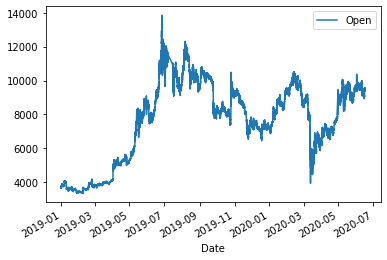

In [9]:
df.plot(x = 'Date', y = 'Open')

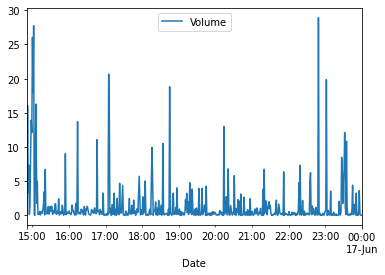

In [10]:
df.iloc[:550].plot(x = 'Date', y = 'Volume')

In [11]:
# Converting to percentage change between the current and prior element
print(df.head())
#df[['Open', 'Volume']] = df[['Open', 'Volume']].pct_change()
df['Open'] = df['Open'].pct_change()
df = df.drop(index = 0) # Drop the first row since it is NaN due to pct_change()
print(df.head())

                 Date     Open    Volume
0 2020-06-17 00:00:00  9526.40  0.020150
1 2020-06-16 23:59:00  9525.68  0.006691
2 2020-06-16 23:58:00  9521.38  0.049345
3 2020-06-16 23:57:00  9525.20  0.292681
4 2020-06-16 23:56:00  9522.95  3.621439
                 Date      Open    Volume
1 2020-06-16 23:59:00 -0.000076  0.006691
2 2020-06-16 23:58:00 -0.000451  0.049345
3 2020-06-16 23:57:00  0.000401  0.292681
4 2020-06-16 23:56:00 -0.000236  3.621439
5 2020-06-16 23:55:00 -0.000003  0.064634


In [12]:
# Converting to a numpy-array, dropping the 'Date'-column and standardizing
df = df[['Open', 'Volume']].to_numpy()
df = (df-df.mean(axis=0))/df.std(axis=0)
print(type(df), df.shape, df[0])

<class 'numpy.ndarray'> (712795, 2) [-0.06260313 -0.18780868]


In [13]:
#df = df[:1000]
#print(df.shape)
#print(df[:10])

In [14]:
# Converting the dataset (numpy-array) to a numpy-array which fits the model
# The first dimension represents the number of examples
# The second dimension represents the length of the time series used to make a prediction
# The third dimension represents the number of features used (e.g. 'Open', 'Volume' etc)

# future_pred = 0 means that we are predicting only one time step in the future
# seq_len represents the length of the time series used to make a prediction
def to_sequences(dataset, seq_len, future_pred):
    
    features = []
    labels = []
    
    i = 0
    #label = dataset[seq_len+future_pred, :]

    while i+seq_len+future_pred < len(dataset):
        feature = dataset[i:i+seq_len, :]
        features.append(feature)
        
        label = dataset[i+seq_len+future_pred, 0]
        labels.append(label)
        
        i += 1
        
    return np.array(features), np.array(labels)
    

In [15]:
#features, labels = to_sequences(dataset = df, seq_len = 3, future_pred = 0)
#print(features.shape, '\n', features)
#print(labels.shape, '\n', labels)

In [16]:
# Generating the training and testing data

train_size = 0.8 # Fraction
seq_len = 10
future_pred = 0

df_train, df_test = df[0:int(train_size*len(df))], df[int(train_size*len(df)):]
x_train, y_train = to_sequences(dataset = df_train, 
                                seq_len = seq_len, 
                                future_pred = future_pred)
x_test, y_test = to_sequences(dataset = df_test, 
                              seq_len = seq_len, 
                              future_pred = future_pred)

In [17]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(570226, 10, 2)
(570226,)
(142549, 10, 2)
(142549,)


In [18]:
# Building model
model = Sequential()
# NOTE - seems like LSTM only has GPU support when using tanh as the activation function!!!
model.add(LSTM(units = 30, input_shape = x_train.shape[1:], activation = 'tanh', return_sequences = False))
model.add(Dense(units = 8, activation = 'relu'))
model.add(Dense(units = 1, activation = 'linear'))

In [19]:
### Defining optimization parameters ###
lr = 0.005
decay = 1e-5

opt = Adam(lr = lr, decay = decay)

model.compile(optimizer = opt, loss = 'mse') #, metrics = ['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30)                3960      
_________________________________________________________________
dense (Dense)                (None, 8)                 248       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 4,217
Trainable params: 4,217
Non-trainable params: 0
_________________________________________________________________


In [20]:
### Train the model ###
batch_size = 512
num_epochs = 5

#NAME = f"{history_size}-SEQ-{target_size}-PRED-{int(time.time())}"
#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

#filepath = "RNN_Final-{epoch:02d}-{val_acc:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
#checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(x = x_train, 
                    y = y_train,
                    epochs = num_epochs,
                    batch_size = batch_size,
                    validation_data = (x_test, y_test),
                    callbacks=[tensorboard_callback])
    
    


Epoch 1/5
1114/1114 [==============================] - 4s 4ms/step - loss: 1.1413 - val_loss: 0.3368
Epoch 2/5
1114/1114 [==============================] - 4s 3ms/step - loss: 1.1306 - val_loss: 0.3315
Epoch 3/5
1114/1114 [==============================] - 4s 4ms/step - loss: 1.1218 - val_loss: 0.3410
Epoch 4/5
1114/1114 [==============================] - 4s 4ms/step - loss: 1.1171 - val_loss: 0.3305
Epoch 5/5
1114/1114 [==============================] - 4s 3ms/step - loss: 1.1116 - val_loss: 0.3355


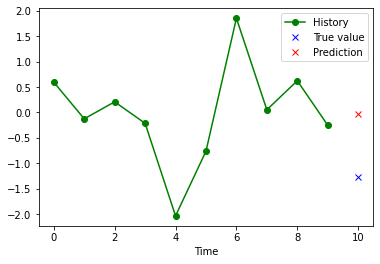

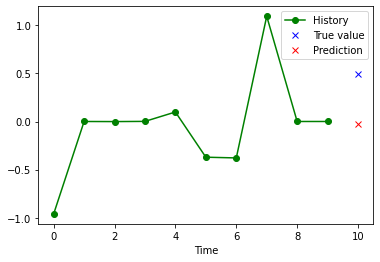

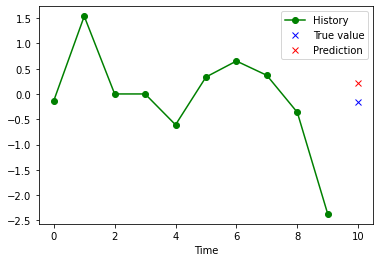

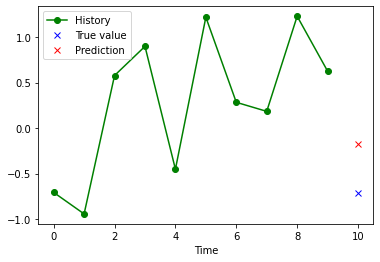

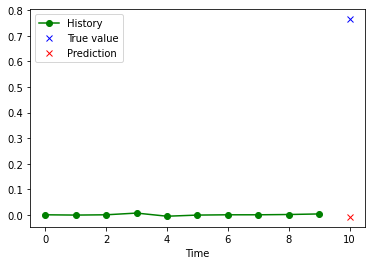

In [85]:
# Plot one example
def plot(x, y, pred = None):
    
    plt.plot(list(range(len(x))), x, '-go', label = 'History')
    plt.plot(len(x), y, 'bx', label = 'True value')
    
    if pred:
        plt.plot(len(x), pred, 'rx', label = 'Prediction')
    
    plt.xlabel('Time')
    plt.legend()
    plt.show()
    

    return

# Plot multiple examples
def plot_multiple(x_train, y_train, model, n = 5):
    
    rand_indexes = [random.randint(0, len(x_train)) for x in range(n)]
    if model:
        preds = [model.predict(x_train[rand_index:rand_index+1]) for rand_index in rand_indexes]
    
    for i, rand_index in enumerate(rand_indexes):
        if model:
            plot(x_train[rand_index, :, 0], y_train[rand_index], preds[i])
        else:
            plot(x_train[rand_index, :, 0], y_train[rand_index])
    
    return

plot_multiple(x_train, y_train, model = model)
#plot(x_train[0, :, 0], y_train[0])
#plot(x_train[1, :, 0], y_train[1])